# Heart Failure Prediction
**Project by Group 21: Hannah Cooper, Joselin Hartanto, Nancy Xu, James Xu**

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/UCB-stat-159-s23/project-Group21.git/HEAD)

## Purpose

The purpose of this project is to analyze the prediction of Heart failure. Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of 5CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs and this dataset contains 11 features that can be used to predict a possible heart disease.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

## EDA

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import sklearn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#### Data from https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

This dataset was created by combining different datasets already available independently but not combined before. In this dataset, 5 heart datasets are combined over 11 common features which makes it the largest heart disease dataset available so far for research purposes. The five datasets used for its curation are:

- Cleveland: 303 observations
- Hungarian: 294 observations
- Switzerland: 123 observations
- Long Beach VA: 200 observations
- Stalog (Heart) Data Set: 270 observations


Total: 1190 observations, 
Duplicated: 272 observations,
Final dataset: 918 observations

In [2]:
# Import raw data
raw_data = pd.read_csv('data/heart.csv')
raw_data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
nan_count = raw_data.isna().sum()
print(nan_count)

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


We note that the categorical columns in the data are Sex, ChestPainType, RestingECG, ExerciseAngina, and ST_Slope, while the rest of the features are quantitative.

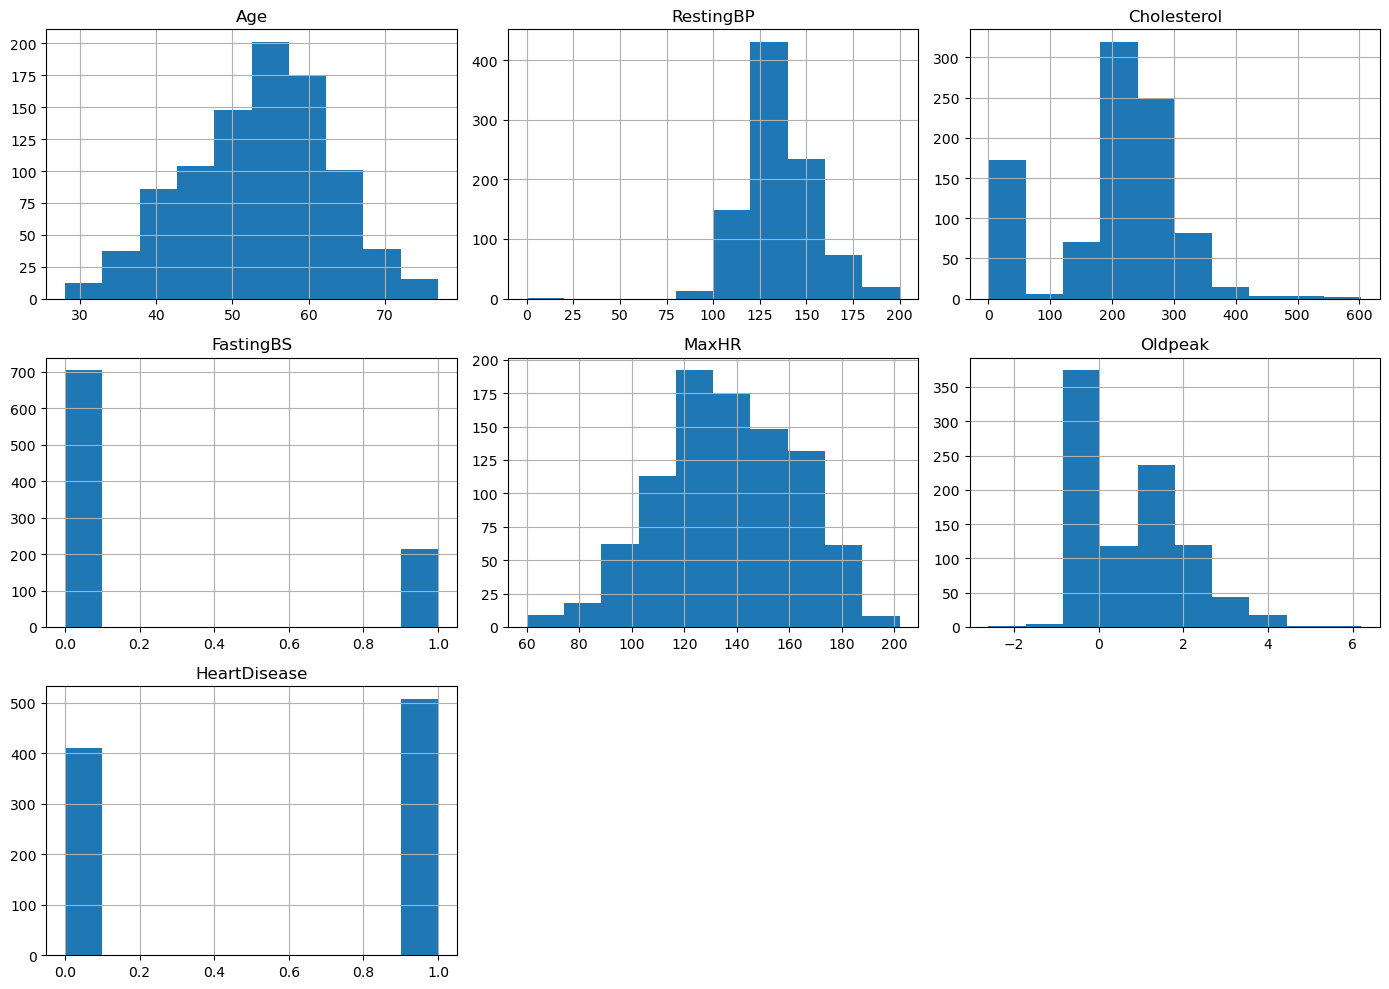

In [4]:
raw_data.hist(figsize=(14, 10))
plt.tight_layout()

Observing the overall distributions for the quantitative features, we see that most of the distributions are skewed. We also observe a noticeable class imbalance in the label, HeartDisease, which may lead to difficulties when we try to fit models to the data.

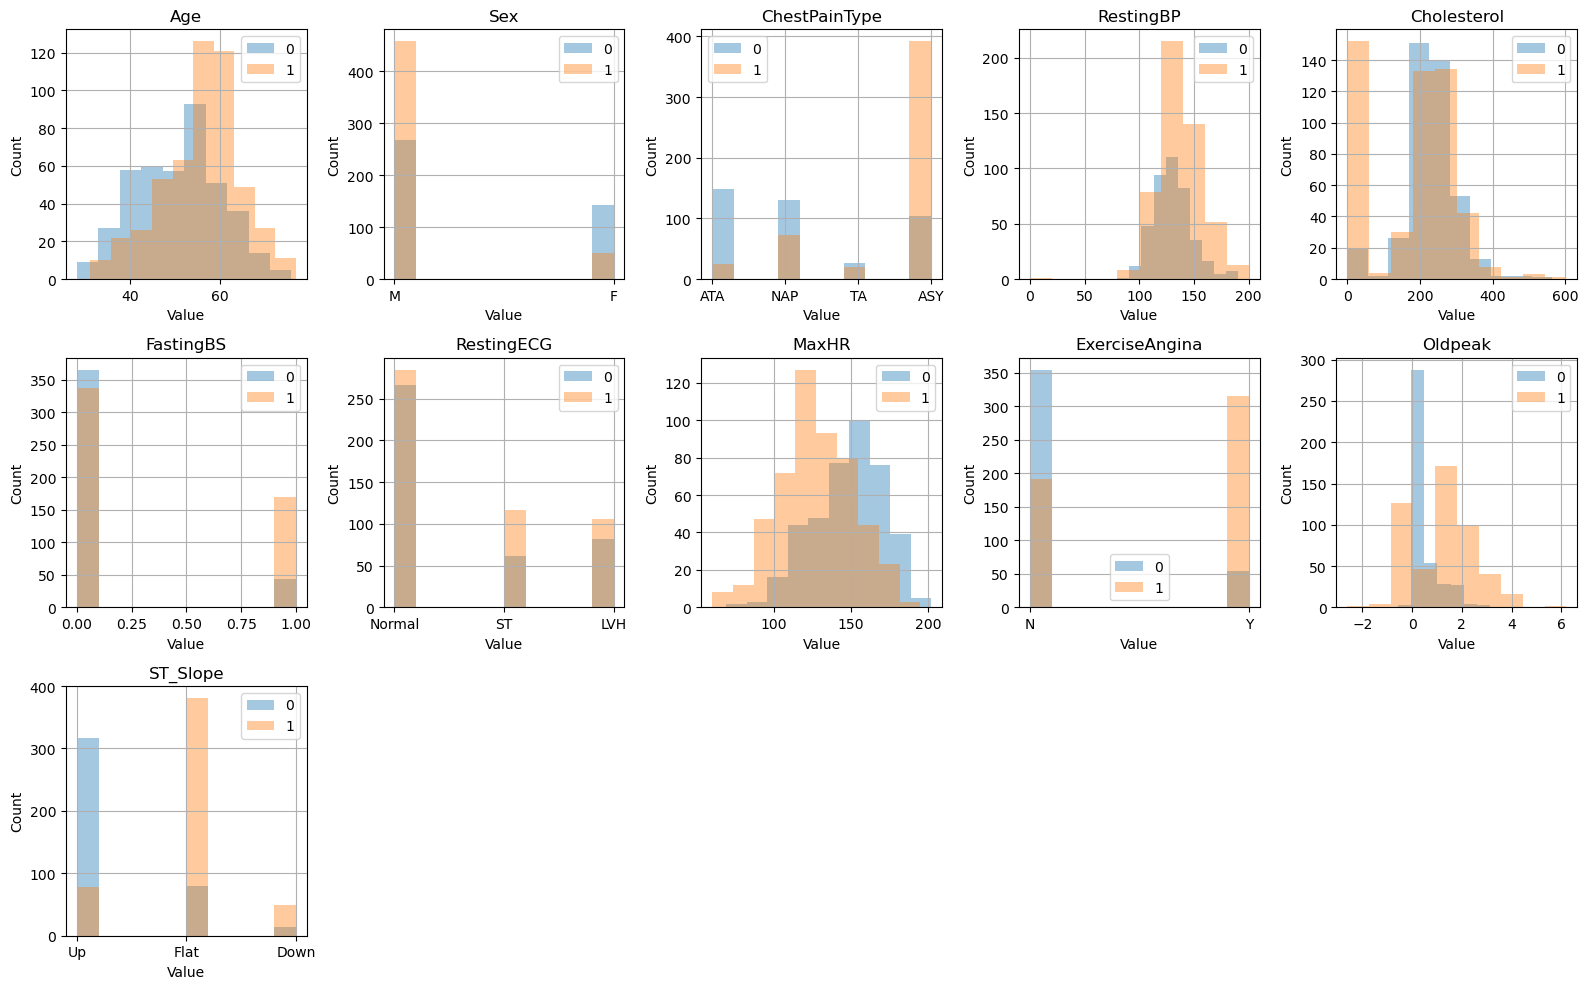

In [5]:
fig,axes = plt.subplots(nrows=3,ncols=5,figsize=(16,10))

# loop through each column in the dataframe
for i, col in enumerate(raw_data.columns[:-1]):
    # select the appropriate subplot axis based on the index i
    ax = axes[i // 5, i % 5]
    # plot a histogram of the column for each group in 'HeartDisease'
    raw_data.groupby('HeartDisease')[col].hist(alpha=0.4, ax=ax)
    # set the title, y-axis label, and x-axis label for the subplot
    ax.set_title(col)
    ax.set_ylabel("Count")
    ax.set_xlabel("Value")
    ax.legend(raw_data['HeartDisease'])

fig.delaxes(axes[2][1])
fig.delaxes(axes[2][2])
fig.delaxes(axes[2][3])
fig.delaxes(axes[2][4])
# adjust the spacing between the subplots for better readability
plt.tight_layout()

Observing the class distribution, we observe that the features Age, Sex, MaxHR, ExerciseAngina, ST_Slopem and OldPeak seem to have noticeably different distribtuions, which indicate that there is a significant variance in the data. We can perform PCA on the non categorical features, to take a look at the structure of the data.

In [6]:
# Remove categorical features
categorical_columns= ['Sex', 'ChestPainType','RestingECG', 'ExerciseAngina', 'ST_Slope' ]
X_pca = raw_data.drop(columns=categorical_columns)
y_pca = raw_data['HeartDisease']

In [7]:
# Standardize the features since they are of different units
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_pca)

In [8]:
# Using PCA
pca = PCA(n_components = 7);
pca.fit(X_standardized);

In [9]:
# Examining the principal components
p_c = pca.fit_transform(X_standardized)
# print(principalComponents)
principal_df = pd.DataFrame(data=p_c, columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7'])
final_df = pd.concat([principal_df, y_pca],axis=1)
final_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,HeartDisease
0,-2.417053,-0.508044,-0.536672,0.492483,-0.592140,0.263087,0.035454,0
1,0.138073,-0.813523,-0.245526,0.495047,-1.577625,-0.012082,0.836385,1
2,-1.346575,0.120716,0.050249,-1.194085,-0.405928,1.707199,-1.379748,0
3,0.768445,-0.416296,0.876559,-0.468257,-0.780828,0.872467,-0.231420,1
4,-0.519631,-0.324544,-1.160150,-1.158588,-0.430199,0.032315,-0.483574,0


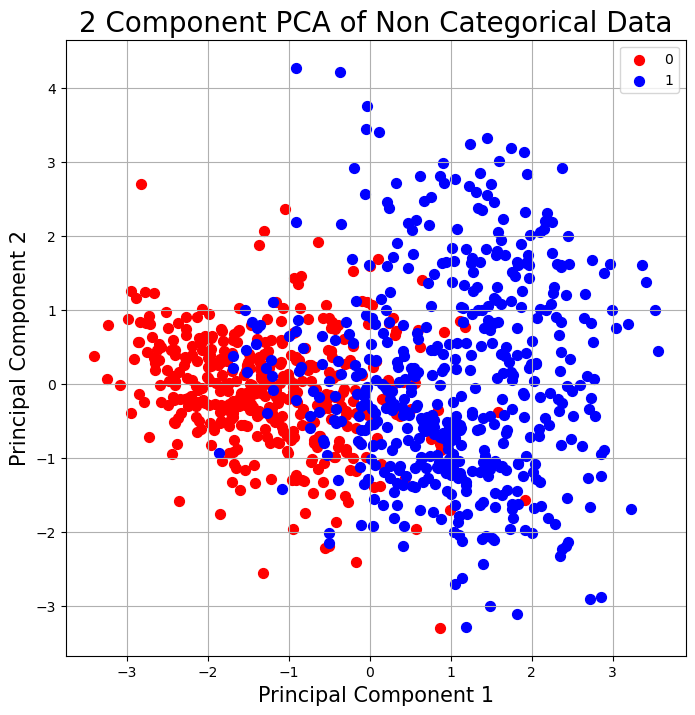

In [10]:
# Plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA of Non Categorical Data', fontsize = 20)
targets = [0,1]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = final_df['HeartDisease'] == target
    ax.scatter(final_df.loc[indicesToKeep, 'PC1']
               , final_df.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

We observe that there seem to be two somewhat distinct clusters, when we project only the non categorical data onto the first two principal components. This indicates that there is indeed seperability of the data.

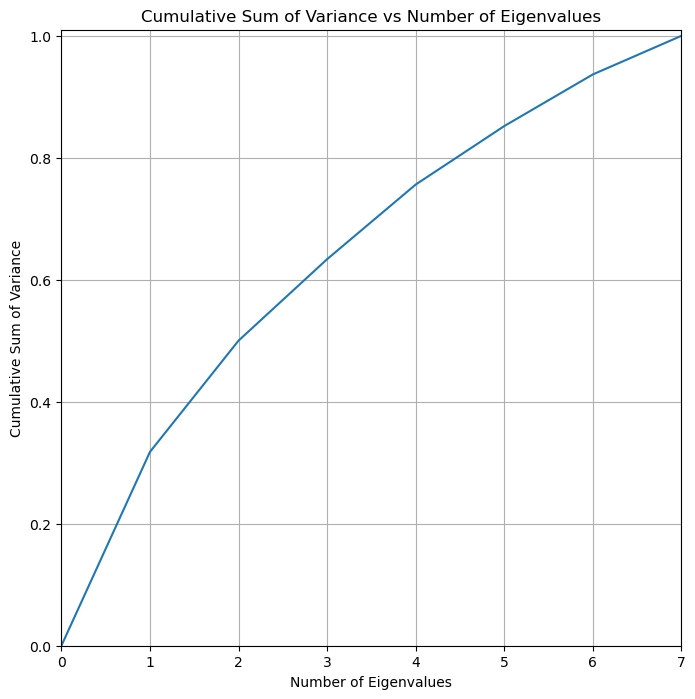

In [11]:
## Variability of components
cum_var = pca.explained_variance_ratio_.cumsum()
cum_var=np.insert(cum_var,0,0)
k_features = list(range(0,X_pca.shape[1]+1))

# Plot figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1,1,1)
ax.plot(k_features,cum_var)
# plt.rc('axes', titlesize=14)
# plt.rc('axes', labelsize=12)
ax.set_xlabel("Number of Eigenvalues")
ax.set_ylabel("Cumulative Sum of Variance")
ax.set_title("Cumulative Sum of Variance vs Number of Eigenvalues")
ax.set_xlim([0,7])
ax.set_ylim([0,1.01])
ax.grid()

We note that the cumulative sum of variance is distributed relatively evenly among the principal components. We note that 5 principal components explains around 85% of the variability in the non categorical data.

# Modeling

In this section, we will preprocess the data and apply various models to predict whether someone has heart disease based on the attributes in the data. 

## Preprocess data

In [12]:
from analysis import utils

We import util functions from util.py to clean the data. This  function one hot encodes the categorical columns, and uses sklearn's preprocessing function MinMaxScaler() to scale the data. It returns the X dataframe with all the features, and and labels y. 

In [13]:
X,y = utils.clean_data(raw_data)

/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


We inspect the columns/features

In [14]:
list(X.columns)

['Age',
 'Cholesterol',
 'FastingBS',
 'MaxHR',
 'Oldpeak',
 'RestingBP',
 'Sex_F',
 'Sex_M',
 'ChestPainType_ASY',
 'ChestPainType_ATA',
 'ChestPainType_NAP',
 'ChestPainType_TA',
 'RestingECG_LVH',
 'RestingECG_Normal',
 'RestingECG_ST',
 'ExerciseAngina_N',
 'ExerciseAngina_Y',
 'ST_Slope_Down',
 'ST_Slope_Flat',
 'ST_Slope_Up']

We then split the data into train and test sets.

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## Modeling

We fit logistic regression, mlp, and random forest models using x_train and y_train, then choose the best model based on the model test accuracies. We then plot the roc curve and saves the roc cure to the folder ./figures. 

The main question we want to focus on is: can models prioritize recall over precision? In the case of predicting heart disease, we care more about FN than FP, since we want to identify as many actual cases of heart disease as possible. This preference would determine how we create the threshold for classification, which we will discuss later.

In [16]:
logisticRegr, clf, RF = utils.fit_models(x_train, y_train, x_test, y_test)

/srv/conda/envs/notebook/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [17]:
best_model, best_test_predictions, best_model_name = utils.choose_best_model(logisticRegr, clf, RF, x_test, y_test)



Best Model is: logistic regression
Recall is: 0.8439716312056738
Precision is: 0.937007874015748


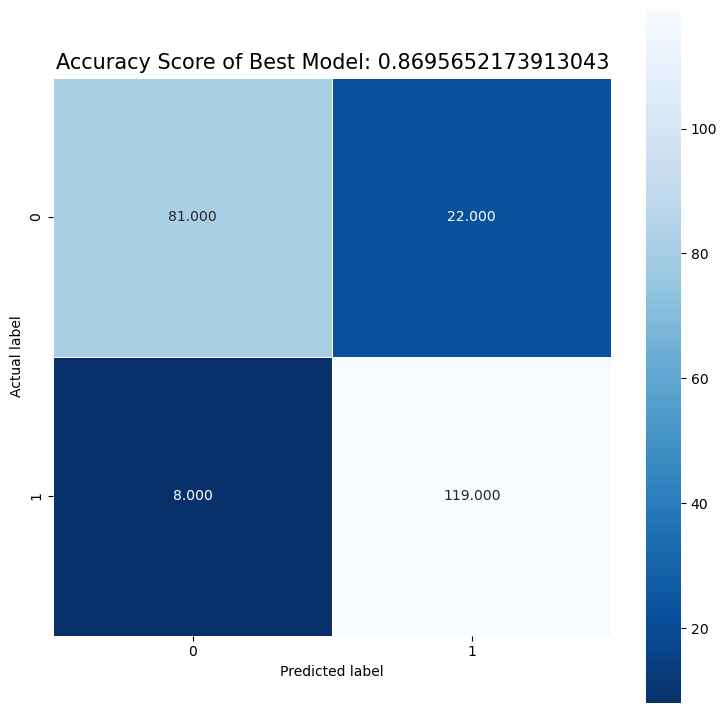

Best Threshold=1.000000
Best model AUC is: 0.8617078205030198


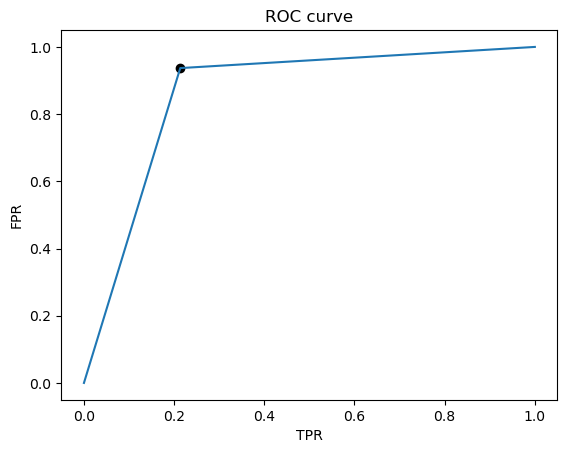

In [18]:
utils.graph_confusion_roc(best_model, x_test, y_test, best_test_predictions, best_model_name, root_dir = '.')

We see that there are more FP than FN, and that although they are pretty close, recall is less than the precision. In our case of predicting heart disease, we probably want to prioritize recall, since we want to detect as many positive cases of heart disease as possible. In other words, we care more about the FN than the FP. Thus we would want to set the threshold to be lower than 0.5 to maximize the recall. Additionally, we could also try to inspect the data that are FN to try to identify a pattern, and then we could augment the training set with these FN's so that the model will learn to better identify positive cases.  

# Author Contributions

Hannah Cooper created the tests for the data preprocessing modeling functions, the license for the project, and created the makefile. Joseline Hartanto created the environment yml file, jupyter book, binder, and contributed to main.ipynb file. James Xu created the notebook for EDA + data cleaning + processing with the corresponding functions, contributed to main.ipynb file, and helped with reproducibility support. Nancy Xu created the notebook for modeling, contributed to main.ipynb file, and helped with testing functions.